#### 1- Importar Bibliotecas

In [ ]:
pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 22.0 MB 164 kB/s
     |████████████████████████████████| 297 kB 21.1 MB/s 
     |████████████████████████████████| 102 kB 77.6 MB/s 
     |████████████████████████████████| 690 kB 26.4 MB/s 
     |████████████████████████████████| 4.7 MB 77.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 9.8 MB 84.4 MB/s 
     |████████████████████████████████| 296 kB 60.9 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.3.1-py2.py3-none-any.whl size=310107 sha256=ec4daaf212578fdf0dc4bf9eafcfeed52419962893ef32b2e36ebb1366f5ff2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-832338n5/wheels/c3/aa/10/94ee985ca5a122f047c430cf991df62fe210c4789d3b5762a5
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=f10f1e20dbf768bfb30a626e280fdb88f2a961a9e54d4f4139857b069730a8a8
  Stored in directo

In [ ]:
!pip install catboost==0.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 13 kB/s 


In [ ]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 31.1 MB/s 


In [ ]:
# Base de Biblioteca e leitura
from google.colab import drive
drive.mount('/content/drive')
from datetime import date

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from pandas_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Mounted at /content/drive


#### 2- Base de Dados GD

In [ ]:
# 1 - Base de Dados GD Completa:
df_geracao = pd.read_csv('/content/drive/MyDrive/datasets/empreendimento-geracao-distribuida.csv', encoding='UTF-16', sep=';')

# 2 - Base de dados por período ( 01/01/2021 - 02/04/2022):
df_geracao_recente =(
    df_geracao
    .query('DthAtualizaCadastralEmpreend >= "2021-01-01" & DthAtualizaCadastralEmpreend < "2022-04-02"'))

# 3 - Base dedados do estado de SP/CNPJ/PERÍODO com eliminação de colunas - dropei três colunas que estão com cpf
df_geracao_recente_sp_CNPJ = (
    df_geracao_recente
    .query('SigUF == "SP" & SigTipoConsumidor == "PJ" & SigTipoGeracao == "UFV"')
    .drop(columns=['DatGeracaoConjuntoDados', 'AnmPeriodoReferencia',
                   'codUFibge','codRegiao','NomRegiao','CodMunicipioIbge',
                   'SigAgente','CodClasseConsumo','CodSubGrupoTarifario',
                   'SigUF',
                   'DscModalidadeHabilitado','SigTipoGeracao','DscFonteGeracao',
                   'SigTipoConsumidor', 'NumCoordESub','NumCoordNSub'])
    .sort_values('NumCPFCNPJ')
    )
df_geracao_recente_sp_CNPJ.drop(index=df_geracao_recente_sp_CNPJ.iloc[0:3].index.tolist(), inplace=True)
df_geracao_recente_sp_CNPJ.rename(columns = {'NumCPFCNPJ':'CNPJ'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### 3- Inclusão da Base CNPJ na base GD

##### 3.1- Funções para melhorar a base

In [ ]:
def limpeza_dados_estabele(dados):
    dados.columns =["CNPJBasico","CNPJordem","CNPJdv","MATRIZ/FILIAL",
                              "NOMEFANTASIA","SITUAÇÃOCADASTRAL","DATA_SITUAÇÃO",
                              "MOTIVO_SITUAÇÃO","NOME_DA_CIDADE","PAIS",
                              "INÍCIO_ATIVIDADE","CNAE_PRINCIPAL","CNAE_SECUNDARIA",
                              "TIPO_DE_LOGRADOURO","LOGRADOURO","NÚMERO","COMPLEMENTO",
                              "BAIRRO","CEP","UF","MUNICÍPIO","DDD_1","TELEFONE_1",
                              "DDD_2","TELEFONE_2","DDD_FAX","FAX","E_MAIL",
                              "SITUACAO_ESPECIAL","DATA_DA_SITUAÇÃO_ESPECIAL"]
                              
    dados = (dados
             .query('UF == "SP"')
             .drop(columns=['NOMEFANTASIA','DDD_1','TELEFONE_1',
                            'DDD_2','TELEFONE_2','DDD_FAX',
                            'FAX','E_MAIL']))
    numero = []
    for row in dados['CNPJBasico']:
        if row < 10 :   numero.append('0000000')
        elif row < 100:  numero.append('000000')
        elif row < 1000:  numero.append('00000')
        elif row < 10000:  numero.append('0000')
        elif row < 100000:  numero.append('000')
        elif row < 1000000:  numero.append('00')
        elif row < 10000000:  numero.append('0')
        else:           numero.append('')
    
    dados['numero'] = numero
    dados['CNPJBasico'] = dados['CNPJBasico'].astype(object)
    dados['numero'] = dados['numero'].astype(object)
    dados['CNPJBasico2']= dados['numero'].map(str) + dados['CNPJBasico'].map(str)


    ordem = []
    for row in dados['CNPJordem']:
        if row < 10 :   ordem.append('000')
        elif row < 100:  ordem.append('00')
        elif row < 1000:  ordem.append('0')
        else:           ordem.append('')


    dados['ordem'] = ordem
    dados['CNPJordem'] = dados['CNPJordem'].astype(object)
    dados['ordem'] = dados['ordem'].astype(object)
    dados['CNPJordem2']= dados['ordem'].map(str) + dados['CNPJordem'].map(str)

    dv = []
    for row in dados['CNPJdv']:
        if row < 10 :   dv.append('0')
        else:           dv.append('')

    dados['dv'] = dv
    dados['CNPJdv'] = dados['CNPJdv'].astype(object)
    dados['dv'] = dados['dv'].astype(object)
    dados['CNPJdv2']= dados['dv'].map(str) + dados['CNPJdv'].map(str)

    dados = (dados
             .drop(columns=['numero','ordem','dv'
             ]))
    
    dados['CNPJ']= dados['CNPJBasico2'].map(str) + dados['CNPJordem2'].map(str)+ dados['CNPJdv2'].map(str)

    dados.insert(0, 'CNPJ', dados.pop('CNPJ'))
    dados.insert(2, 'CNPJBasico2', dados.pop('CNPJBasico2'))
    dados.insert(4, 'CNPJordem2', dados.pop('CNPJordem2'))
    dados.insert(6, 'CNPJdv2', dados.pop('CNPJdv2'))

    dados = (
    dados
    .merge(df_geracao_recente_sp_CNPJ, on='CNPJ', how='left', indicator=True))
    
    dados = dados.query('_merge == "both"')
      
    return dados

In [ ]:
def limpeza_dados_empresas(dados):
    dados.columns =["CNPJBasico","Razao_Social","Natureza_Juridica","Quali_Resp",
                    "Capital_Social","Porte_Empresa","Ente_Resp"]
    
    dados = (df_CNPJ_estabele_gd.merge(dados, on='CNPJBasico', how='left', indicator=True))
    
    dados = dados.query('_merge == "both"')
     
    return dados

##### 3.2- Base de Dados CNPJ

In [ ]:
# 1 - Ler base de dados de estabelecimento completa
zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos0.zip')
df_CNPJ_estabele_Y0 = pd.read_csv(zf.open('K3241.K03200Y0.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y0 = limpeza_dados_estabele(df_CNPJ_estabele_Y0)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos1.zip')
df_CNPJ_estabele_Y1 = pd.read_csv(zf.open('K3241.K03200Y1.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y1 = limpeza_dados_estabele(df_CNPJ_estabele_Y1)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos2.zip')
df_CNPJ_estabele_Y2 = pd.read_csv(zf.open('K3241.K03200Y2.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y2 = limpeza_dados_estabele(df_CNPJ_estabele_Y2)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos3.zip')
df_CNPJ_estabele_Y3 = pd.read_csv(zf.open('K3241.K03200Y3.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y3 = limpeza_dados_estabele(df_CNPJ_estabele_Y3)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos4.zip')
df_CNPJ_estabele_Y4 = pd.read_csv(zf.open('K3241.K03200Y4.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y4 = limpeza_dados_estabele(df_CNPJ_estabele_Y4)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos5.zip')
df_CNPJ_estabele_Y5 = pd.read_csv(zf.open('K3241.K03200Y5.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y5 = limpeza_dados_estabele(df_CNPJ_estabele_Y5)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos6.zip')
df_CNPJ_estabele_Y6 = pd.read_csv(zf.open('K3241.K03200Y6.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y6 = limpeza_dados_estabele(df_CNPJ_estabele_Y6)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos7.zip')
df_CNPJ_estabele_Y7 = pd.read_csv(zf.open('K3241.K03200Y7.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y7 = limpeza_dados_estabele(df_CNPJ_estabele_Y7)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos8.zip')
df_CNPJ_estabele_Y8 = pd.read_csv(zf.open('K3241.K03200Y8.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y8 = limpeza_dados_estabele(df_CNPJ_estabele_Y8)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Estabelecimentos9.zip')
df_CNPJ_estabele_Y9 = pd.read_csv(zf.open('K3241.K03200Y9.D20709.ESTABELE'), encoding='latin-1', sep=';',header=None)
df_CNPJ_estabele_Y9 = limpeza_dados_estabele(df_CNPJ_estabele_Y9)

df_CNPJ_estabele_gd = pd.concat(
    [df_CNPJ_estabele_Y0, df_CNPJ_estabele_Y1,df_CNPJ_estabele_Y2, df_CNPJ_estabele_Y3,
     df_CNPJ_estabele_Y4,df_CNPJ_estabele_Y5,df_CNPJ_estabele_Y6,df_CNPJ_estabele_Y7,
     df_CNPJ_estabele_Y8,df_CNPJ_estabele_Y9])

df_CNPJ_estabele_gd = (df_CNPJ_estabele_gd.drop(columns=['_merge']))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,18,21,22,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,21,22,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,21,22,24,25,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,22,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# 2 - Ler base de dados de empresas completa
zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas0.zip')
df_CNPJ_empresas0 = pd.read_csv(zf.open('K3241.K03200Y0.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas0 = limpeza_dados_empresas(df_CNPJ_empresas0)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas1.zip')
df_CNPJ_empresas1 = pd.read_csv(zf.open('K3241.K03200Y1.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas1 = limpeza_dados_empresas(df_CNPJ_empresas1)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas2.zip')
df_CNPJ_empresas2 = pd.read_csv(zf.open('K3241.K03200Y2.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas2 = limpeza_dados_empresas(df_CNPJ_empresas2)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas3.zip')
df_CNPJ_empresas3 = pd.read_csv(zf.open('K3241.K03200Y3.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas3 = limpeza_dados_empresas(df_CNPJ_empresas3)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas4.zip')
df_CNPJ_empresas4 = pd.read_csv(zf.open('K3241.K03200Y4.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas4 = limpeza_dados_empresas(df_CNPJ_empresas4)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas5.zip')
df_CNPJ_empresas5 = pd.read_csv(zf.open('K3241.K03200Y5.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas5 = limpeza_dados_empresas(df_CNPJ_empresas5)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas6.zip')
df_CNPJ_empresas6 = pd.read_csv(zf.open('K3241.K03200Y6.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas6 = limpeza_dados_empresas(df_CNPJ_empresas6)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas7.zip')
df_CNPJ_empresas7 = pd.read_csv(zf.open('K3241.K03200Y7.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas7 = limpeza_dados_empresas(df_CNPJ_empresas7)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas8.zip')
df_CNPJ_empresas8 = pd.read_csv(zf.open('K3241.K03200Y8.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas8 = limpeza_dados_empresas(df_CNPJ_empresas8)

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Empresas9.zip')
df_CNPJ_empresas9 = pd.read_csv(zf.open('K3241.K03200Y9.D20709.EMPRECSV'), encoding='latin-1', sep=';',header=None)
df_CNPJ_empresas9 = limpeza_dados_empresas(df_CNPJ_empresas9)

df_CNPJ_estabele_empresas_gd = pd.concat(
    [df_CNPJ_empresas0, df_CNPJ_empresas1,df_CNPJ_empresas2, df_CNPJ_empresas3,
     df_CNPJ_empresas4,df_CNPJ_empresas5,df_CNPJ_empresas6,df_CNPJ_empresas7,
     df_CNPJ_empresas8,df_CNPJ_empresas9
     ])

df_CNPJ_estabele_empresas_gd = (
    df_CNPJ_estabele_empresas_gd
    .drop(columns=['_merge']))

df_CNPJ_estabele_empresas_gd['CNPJBasico'] = df_CNPJ_estabele_empresas_gd['CNPJBasico'].astype(int)

In [ ]:
# 3 - Ler base de dados Simples completa
zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/CNPJ/Simples.zip')
df_CNPJ_simples = pd.read_csv(zf.open('F.K03200$W.SIMPLES.CSV.D20709'), encoding='latin-1', sep=';',header=None)
df_CNPJ_simples.columns =["CNPJBasico","Simples","DATA_Simples","DATA_exclusao_Simples","MEI","DATA_MEI","DATA_exclusao_MEI"]
df_CNPJ_simples = (df_CNPJ_estabele_empresas_gd.merge(df_CNPJ_simples, on='CNPJBasico', how='left', indicator=True))
df_CNPJ_simples['Simples'] = df_CNPJ_simples['Simples'].fillna('N')
df_CNPJ_simples['MEI'] = df_CNPJ_simples['MEI'].fillna('N')

df_CNPJ_simples['MdaPotenciaInstaladaKW'] = df_CNPJ_simples['MdaPotenciaInstaladaKW'].str.replace(',', '.')
df_CNPJ_simples['MdaPotenciaInstaladaKW'] = df_CNPJ_simples['MdaPotenciaInstaladaKW'].astype(float)
df_CNPJ_simples['DthAtualizaCadastralEmpreend'] = pd.to_datetime(df_CNPJ_simples['DthAtualizaCadastralEmpreend'])
df_CNPJ_simples['INÍCIO_ATIVIDADE'] = pd.to_datetime(df_CNPJ_simples['INÍCIO_ATIVIDADE'], format='%Y%m%d')
df_CNPJ_simples['recencia_emprendimento']= (pd.to_datetime(date.today()) - pd.to_datetime(df_CNPJ_simples['DthAtualizaCadastralEmpreend'])).dt.days
df_CNPJ_simples['recencia_emprendimento']= df_CNPJ_simples['recencia_emprendimento'].astype(int)
df_CNPJ_simples['recencia_empresa']= (pd.to_datetime(date.today())- pd.to_datetime(df_CNPJ_simples['INÍCIO_ATIVIDADE'], format='%Y%m%d')).dt.days
df_CNPJ_simples['recencia_empresa']= df_CNPJ_simples['recencia_empresa'].astype(int)
#df_CNPJ_simples['recencia_emprendimento_grupo']=pd.cut(df_CNPJ_simples['recencia_emprendimento'],bins = [53,157,248,361,507], labels = [0,1,2,3])
#df_CNPJ_simples['recencia_empresa_grupo']=pd.cut(df_CNPJ_simples['recencia_empresa'],bins = [99,3153,5594,8674,21864], labels = [0,1,2,3])
df_CNPJ_simples['capital_social_num'] = df_CNPJ_simples['Capital_Social'].str.replace(',', '.')
df_CNPJ_simples['capital_social_num'] = df_CNPJ_simples['capital_social_num'].astype(float)
#df_CNPJ_simples['capital_social_grupo']=pd.cut(df_CNPJ_simples['capital_social_num'],bins = [-1,10000,100000,4000000,58042463613.60], labels = [0,1,2,3])
df_CNPJ_simples['QtdUCRecebeCredito'] = df_CNPJ_simples['QtdUCRecebeCredito'].astype(int)
df_CNPJ_simples['Natureza_Juridica'] = df_CNPJ_simples['Natureza_Juridica'].astype(object)
df_CNPJ_simples['Quali_Resp'] = df_CNPJ_simples['Quali_Resp'].astype(object)
df_CNPJ_simples['Porte_Empresa'] = df_CNPJ_simples['Porte_Empresa'].astype(object)

numero = []
for row in df_CNPJ_simples['CNAE_PRINCIPAL']:
    if row < 1000000 :   numero.append('0')
    else:           numero.append('')

df_CNPJ_simples['numero'] = numero
df_CNPJ_simples['CNAE_PRINCIPAL2'] = df_CNPJ_simples['CNAE_PRINCIPAL'].astype(object)
df_CNPJ_simples['numero'] = df_CNPJ_simples['numero'].astype(object)
df_CNPJ_simples['CNAE_PRINCIPAL2']= df_CNPJ_simples['numero'].map(str) + df_CNPJ_simples['CNAE_PRINCIPAL'].map(str)
df_CNPJ_simples['CNAE_Clas'] = df_CNPJ_simples.CNAE_PRINCIPAL2.str[:2]



In [ ]:
# 4- Ler a base de dados de CNAE
df_CNAE = pd.read_csv('/content/drive/MyDrive/datasets/CNAE.csv',encoding='latin-1', sep=';')

ordem = []
for row in df_CNAE['Divisão']:
    if row < 10 :   ordem.append('0')
    else:           ordem.append('')
    
df_CNAE['ordem'] = ordem
df_CNAE['Divisão'] = df_CNAE['Divisão'].astype(object)
df_CNAE['ordem'] = df_CNAE['ordem'].astype(object)
df_CNAE['Divisão']= df_CNAE['ordem'].map(str) + df_CNAE['Divisão'].map(str)
df_CNAE['CNAE_Clas'] = df_CNAE['Divisão']

df_CNAE = (
    df_CNAE
    .drop(columns=['ordem', 'Divisão'])
    )

In [ ]:
df_CNAE.head()

,Denominação,Seção,CNAE_Clas
0,"AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS","AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",01
1,PRODUÇÃO FLORESTAL,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",02
2,PESCA E AQÜICULTURA,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...",03
3,EXTRAÇÃO DE CARVÃO MINERAL,INDÚSTRIAS EXTRATIVAS,05
4,EXTRAÇÃO DE PETRÓLEO E GÁS NATURAL,INDÚSTRIAS EXTRATIVAS,06


In [ ]:
# 5 Elaborar a ABT
df_CNPJ_simples_abt =df_CNPJ_simples[['DscClasseConsumo', 'DscSubGrupoTarifario', 'CodEmpreendimento',
       'DthAtualizaCadastralEmpreend', 'SigModalidadeEmpreendimento',
       'QtdUCRecebeCredito', 'DscPorte', 'MdaPotenciaInstaladaKW','CNPJ',
       'CNPJBasico2', 'MATRIZ/FILIAL', 'MOTIVO_SITUAÇÃO', 'INÍCIO_ATIVIDADE',
       'CNAE_PRINCIPAL2', 'Razao_Social', 'Natureza_Juridica',
       'Quali_Resp', 'capital_social_num', 'Porte_Empresa',
       'Simples', 'MEI', 'recencia_emprendimento', 'recencia_empresa','NomMunicipio','CNAE_Clas']]

df_CNPJ_simples_abt = (
    df_CNPJ_simples_abt
    .merge(df_CNAE, on='CNAE_Clas', how='left', indicator=False)
)

In [ ]:
df_CNPJ_simples_abt['MATRIZ/FILIAL'] = df_CNPJ_simples_abt['MATRIZ/FILIAL'].astype(object)
df_CNPJ_simples_abt['MOTIVO_SITUAÇÃO'] = df_CNPJ_simples_abt['MOTIVO_SITUAÇÃO'].astype(object)

#### 4- modelagem

In [ ]:
df_CNPJ_simples_abt.dtypes

DscClasseConsumo                        object
DscSubGrupoTarifario                    object
CodEmpreendimento                       object
DthAtualizaCadastralEmpreend    datetime64[ns]
SigModalidadeEmpreendimento             object
QtdUCRecebeCredito                       int64
DscPorte                                object
MdaPotenciaInstaladaKW                 float64
CNPJ                                    object
CNPJBasico2                             object
MATRIZ/FILIAL                           object
MOTIVO_SITUAÇÃO                         object
INÍCIO_ATIVIDADE                datetime64[ns]
CNAE_PRINCIPAL2                         object
Razao_Social                            object
Natureza_Juridica                       object
Quali_Resp                              object
capital_social_num                     float64
Porte_Empresa                           object
Simples                                 object
MEI                                     object
recencia_empr

In [ ]:
df_CNPJ_simples_abt.shape

(8656, 27)

In [ ]:
##Análise de dados faltantes
df_CNPJ_simples_abt.isna().sum()

DscClasseConsumo                0
DscSubGrupoTarifario            0
CodEmpreendimento               0
DthAtualizaCadastralEmpreend    0
SigModalidadeEmpreendimento     0
QtdUCRecebeCredito              0
DscPorte                        0
MdaPotenciaInstaladaKW          0
CNPJ                            0
CNPJBasico2                     0
MATRIZ/FILIAL                   0
MOTIVO_SITUAÇÃO                 0
INÍCIO_ATIVIDADE                0
CNAE_PRINCIPAL2                 0
Razao_Social                    0
Natureza_Juridica               0
Quali_Resp                      0
capital_social_num              0
Porte_Empresa                   0
Simples                         0
MEI                             0
recencia_emprendimento          0
recencia_empresa                0
NomMunicipio                    0
CNAE_Clas                       0
Denominação                     0
Seção                           0
dtype: int64

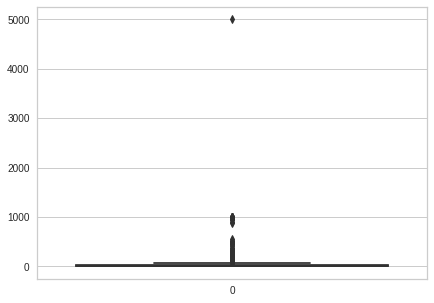

In [ ]:
### Análise de Outliers
fig, ax = plt.subplots(figsize=(7,5))

sns.boxplot(data=df_CNPJ_simples_abt['MdaPotenciaInstaladaKW'])

#Boxplot apontou existência de outliers a partir do valor de 80 kWs de potência, porém não faz sentido para o negócio retirar os dados, 
#pois a partir de 75 Kw que o empreendimento altera a configuração de microgeração para minigeração

In [ ]:
### Separação de Dados- Separação OOT
# Criando df_train e df_test
df_train =(
    df_CNPJ_simples_abt
    .query('DthAtualizaCadastralEmpreend >= "2021-01-01" & DthAtualizaCadastralEmpreend < "2022-01-01"')
    .drop(columns=['CodEmpreendimento','Razao_Social','CNPJBasico2','CNPJ','CNAE_Clas','NomMunicipio','recencia_emprendimento'])
)

df_test = (
    df_CNPJ_simples_abt
    .query('DthAtualizaCadastralEmpreend >= "2022-01-01" & DthAtualizaCadastralEmpreend < "2022-03-29"')
    .drop(columns=['CodEmpreendimento','Razao_Social','CNPJBasico2','CNPJ','CNAE_Clas','NomMunicipio','recencia_emprendimento'])
    )

df_train['MATRIZ/FILIAL'] = df_train['MATRIZ/FILIAL'].astype(object)
df_train['MOTIVO_SITUAÇÃO'] = df_train['MOTIVO_SITUAÇÃO'].astype(object)
#df_train['capital_social_grupo'] = df_train['capital_social_grupo'].astype(object)
#df_train['recencia_emprendimento_grupo'] = df_train['recencia_emprendimento_grupo'].astype(object)
#df_train['recencia_empresa_grupo'] = df_train['recencia_empresa_grupo'].astype(object)


df_test['MATRIZ/FILIAL'] = df_test['MATRIZ/FILIAL'].astype(object)
df_test['MOTIVO_SITUAÇÃO'] = df_test['MOTIVO_SITUAÇÃO'].astype(object)
#df_test['capital_social_grupo'] = df_test['capital_social_grupo'].astype(object)
#df_test['recencia_emprendimento_grupo'] = df_test['recencia_emprendimento_grupo'].astype(object)
#df_test['recencia_empresa_grupo'] = df_test['recencia_empresa_grupo'].astype(object)

In [ ]:
df_train.describe()

,QtdUCRecebeCredito,MdaPotenciaInstaladaKW,capital_social_num,recencia_empresa
count,6950.000000,6950.000000,6.950000e+03,6950.000000
mean,1.367050,31.022832,1.644163e+08,6693.766331
std,1.536651,83.878985,1.883253e+09,4676.211092
min,1.000000,0.000000,0.000000e+00,317.000000
25%,1.000000,8.000000,0.000000e+00,3302.250000
50%,1.000000,17.000000,1.000000e+04,5767.000000
75%,1.000000,36.000000,1.000000e+05,8947.500000
max,45.000000,5000.000000,5.813052e+10,21999.000000


In [ ]:
df_test.describe()

,QtdUCRecebeCredito,MdaPotenciaInstaladaKW,capital_social_num,recencia_empresa
count,1704.000000,1704.000000,1.704000e+03,1704.000000
mean,1.325117,27.646931,6.965789e+07,6363.359155
std,0.931565,47.037905,1.183867e+09,4523.035293
min,1.000000,0.450000,0.000000e+00,236.000000
25%,1.000000,8.000000,0.000000e+00,3225.000000
50%,1.000000,16.000000,5.000000e+03,5612.500000
75%,1.000000,35.000000,9.540000e+04,8207.250000
max,14.000000,1000.000000,3.095138e+10,20550.000000


In [ ]:
### Separação de Dados- Separação aleatória
# Criando Y train/ X Train e Y test/ X test

target = ['MdaPotenciaInstaladaKW']
cat_vars = df_train.select_dtypes(include=['object']).columns.to_list()
num_vars = ['QtdUCRecebeCredito','capital_social_num','recencia_empresa']

X = df_CNPJ_simples_abt.filter(cat_vars + num_vars).copy()
y = df_CNPJ_simples_abt[target].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.describe()

,QtdUCRecebeCredito,capital_social_num,recencia_empresa
count,6924.000000,6.924000e+03,6924.000000
mean,1.360485,1.344788e+08,6619.347487
std,1.456492,1.581076e+09,4637.744199
min,1.000000,0.000000e+00,236.000000
25%,1.000000,0.000000e+00,3269.000000
50%,1.000000,1.000000e+04,5736.500000
75%,1.000000,1.000000e+05,8798.250000
max,45.000000,5.813052e+10,21167.000000


In [ ]:
y_train.describe()

,MdaPotenciaInstaladaKW
count,6924.000000
mean,30.170661
std,81.607933
min,0.000000
25%,8.000000
50%,16.550000
75%,36.000000
max,5000.000000


In [ ]:
X_test.describe()

,QtdUCRecebeCredito,capital_social_num,recencia_empresa
count,1732.000000,1.732000e+03,1732.000000
mean,1.351617,1.906825e+08,6662.237298
std,1.360257,2.371392e+09,4689.368169
min,1.000000,0.000000e+00,351.000000
25%,1.000000,0.000000e+00,3339.250000
50%,1.000000,1.000000e+04,5675.000000
75%,1.000000,1.000000e+05,8887.750000
max,35.000000,5.813052e+10,21999.000000


In [ ]:
y_test.describe()

,MdaPotenciaInstaladaKW
count,1732.000000
mean,31.110693
std,61.603056
min,0.500000
25%,8.000000
50%,17.000000
75%,36.000000
max,1000.000000


In [ ]:
# Criando Y train/ X Train e Y test/ X test  na base OOT (OPÇÃO ESCOLHIDA)

target = ['MdaPotenciaInstaladaKW']
cat_vars = df_train.select_dtypes(include=['object']).columns.to_list()
num_vars = ['QtdUCRecebeCredito','capital_social_num','recencia_empresa']

X_train = df_train.filter(cat_vars + num_vars).copy()
y_train = df_train[target].copy()
X_test = df_test.filter(cat_vars + num_vars).copy()
y_test = df_test[target].copy()

In [ ]:
#MODELAGEM
## Criar Função
def adjusted_r2(y_esperado, y_previsto, X_treino):
  R2 = r2_score(y_esperado, y_previsto)
  N = len(y_esperado)
  p = X_treino.shape[1]

  r2_ajustado = (1 - ((1 - R2) * (N - 1)) / (N - p - 1))
  return r2_ajustado

def log_results(modelo_objeto, nome_modelo, X_train, X_test, y_train, y_test):
    pd.options.display.float_format = '{:.4f}'.format
    metricas = {
        'modelo': [nome_modelo, nome_modelo],
        'modo': ['treino', 'teste'],
        'r2': [r2_score(y_train, modelo_objeto.predict(X_train)), r2_score(y_test, modelo_objeto.predict(X_test))],
        'r2_ajustado': [adjusted_r2(y_train, modelo_objeto.predict(X_train),X_train), adjusted_r2(y_test, modelo_objeto.predict(X_test),X_test)],
        'mse': [mean_squared_error(y_train, modelo_objeto.predict(X_train)), mean_squared_error(y_test, modelo_objeto.predict(X_test))],
        'rmse': [mean_squared_error(y_train, modelo_objeto.predict(X_train), squared=False), mean_squared_error(y_test, modelo_objeto.predict(X_test), squared=False)],

        'mae': [mean_absolute_error(y_train, modelo_objeto.predict(X_train)), mean_absolute_error(y_test, modelo_objeto.predict(X_test))],
        'medae': [median_absolute_error(y_train, modelo_objeto.predict(X_train)), median_absolute_error(y_test, modelo_objeto.predict(X_test))],
        'mape': [mean_absolute_percentage_error(y_train, modelo_objeto.predict(X_train)), mean_absolute_percentage_error(y_test, modelo_objeto.predict(X_test))],
        'max_error': [max_error(y_train, modelo_objeto.predict(X_train)), max_error(y_test, modelo_objeto.predict(X_test))]
        }

    return pd.DataFrame(metricas)


In [ ]:
## Regressão Linear

lr_model = Pipeline(steps=[
                           ('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                           ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                           ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                           #('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                           #('min_max_scaler', SklearnTransformerWrapper(transformer=MinMaxScaler(), variables=num_vars)),
                           ('lr', LinearRegression())])


lr_model.fit(X_train, y_train)

y_previsto = lr_model.predict(X_test)
y_esperado = y_test.copy()
r2_score(y_test, y_previsto)
lr_results = log_results(lr_model, 'Regressão Linear', X_train, X_test, y_train, y_test)
lr_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Regressão Linear,treino,0.4645,0.4631,3767.3316,61.3786,18.5221,10.6963,12773115153282.5371,3953.1274
1,Regressão Linear,teste,0.5325,0.5277,1033.8656,32.1538,18.7426,11.8884,1.8090,533.9061


In [ ]:
## Ridge Regression

ridge_model = Pipeline(steps=[('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                              ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                              ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                              ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                              ('model', Ridge())])

ridge_model.fit(X_train, y_train)

y_previsto = ridge_model.predict(X_test)
y_esperado = y_test.copy()
ridge_results = log_results(ridge_model, 'Ridge Regression', X_train, X_test, y_train, y_test)
ridge_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Ridge Regression,treino,0.4608,0.4594,3793.4234,61.5908,18.6451,10.8586,12769949966723.4473,4003.0074
1,Ridge Regression,teste,0.5523,0.5478,989.9644,31.4637,18.2820,11.7863,1.7521,563.2652


In [ ]:
## Arvore de regressão

tree_model = Pipeline(steps=[#('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                              ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                              ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                              ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                              ('decision_tree', DecisionTreeRegressor(random_state=30,max_depth=3))
                              ])

# Execute para criar o modelo
tree_model.fit(X_train, y_train)

y_previsto = tree_model.predict(X_test)
y_esperado = y_test.copy()

tree_results = log_results(tree_model, 'Decision Tree', X_train, X_test, y_train, y_test)

tree_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Decision Tree,treino,0.8430,0.8426,1104.7455,33.2377,18.2950,14.5462,14933958125018.6797,769.5734
1,Decision Tree,teste,0.7141,0.7112,632.3043,25.1457,17.4397,14.5462,1.7438,265.4734


In [ ]:
# Random forest Regressor

rf_model = Pipeline(steps=[('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                           ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                           ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                           ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                           ('random_forest', RandomForestRegressor(random_state=30,max_depth=3))
                           ])

# Execute para criar o modelo
rf_model.fit(X_train, y_train)

y_previsto = rf_model.predict(X_test)
y_esperado = y_test.copy()

rf_results = log_results(rf_model, 'Random Forest', X_train, X_test, y_train, y_test)

rf_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `ne

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Random Forest,treino,0.8085,0.8081,1346.8141,36.6990,18.3772,14.1364,14135862253362.2246,1367.2243
1,Random Forest,teste,0.7188,0.7160,621.7934,24.9358,17.3908,14.6676,1.7619,284.3854


In [ ]:
#LGBM Regressor


lgbm_model = Pipeline(steps=[('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                             ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                             ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                             ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                             ('LGBM', LGBMRegressor(random_state=30))
                              ])

# Execute para criar o modelo
lgbm_model.fit(X_train, y_train)

y_previsto = lgbm_model.predict(X_test)
y_esperado = y_test.copy()

lgbm_results = log_results(lgbm_model, 'LighGBM', X_train, X_test, y_train, y_test)

lgbm_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,LighGBM,treino,0.6530,0.6521,2441.0918,49.4074,14.9979,9.6646,15083995813935.3984,3349.1506
1,LighGBM,teste,0.6967,0.6937,670.6517,25.8969,16.0531,11.6825,1.5137,385.0562


In [ ]:
# XGBoost Regressor

xgb_model = Pipeline(steps=[('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                            ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                            ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                            ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                            ('xgb', XGBRegressor(random_state=30))
                            ])

# Execute para criar o modelo
xgb_model.fit(X_train, y_train)

y_previsto = xgb_model.predict(X_test)
y_esperado = y_test.copy()

xgb_results = log_results(xgb_model, 'XGBoost', X_train, X_test, y_train, y_test)

xgb_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0


[22:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,XGBoost,treino,0.8980,0.8978,717.2855,26.7822,16.0243,12.1781,15081157825056.7578,506.2691
1,XGBoost,teste,0.6510,0.6475,771.7694,27.7807,16.7132,13.2375,1.6428,465.4576


In [ ]:
#Catboost

from catboost import CatBoostRegressor

cat_model = Pipeline(steps=[('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
                            ('standard_scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables=num_vars)),
                            ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars, return_object=True)),
                            ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                            ('catboost', CatBoostRegressor(random_state=30))
                            ])

# Execute para criar o modelo
cat_model.fit(X_train, y_train)

y_previsto = cat_model.predict(X_test)
y_esperado = y_test.copy()

cat_results = log_results(cat_model, 'CatBoost', X_train, X_test, y_train, y_test)

cat_results

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0


Learning rate set to 0.055116
0:	learn: 82.1242593	total: 55.4ms	remaining: 55.3s
1:	learn: 80.5079842	total: 59.7ms	remaining: 29.8s
2:	learn: 78.9851582	total: 63.6ms	remaining: 21.1s
3:	learn: 77.4398758	total: 67.2ms	remaining: 16.7s
4:	learn: 76.0313669	total: 71ms	remaining: 14.1s
5:	learn: 74.6910016	total: 76.4ms	remaining: 12.7s
6:	learn: 73.3165552	total: 80.3ms	remaining: 11.4s
7:	learn: 72.0792228	total: 84.3ms	remaining: 10.4s
8:	learn: 70.8302675	total: 87.7ms	remaining: 9.66s
9:	learn: 69.6838486	total: 91.3ms	remaining: 9.04s
10:	learn: 68.5734545	total: 95.4ms	remaining: 8.58s
11:	learn: 67.4478103	total: 99.4ms	remaining: 8.18s
12:	learn: 66.3659631	total: 103ms	remaining: 7.85s
13:	learn: 65.3308833	total: 107ms	remaining: 7.53s
14:	learn: 64.3557640	total: 110ms	remaining: 7.25s
15:	learn: 63.4116689	total: 114ms	remaining: 7.03s
16:	learn: 62.4389759	total: 119ms	remaining: 6.85s
17:	learn: 61.5886013	total: 123ms	remaining: 6.7s
18:	learn: 60.7214910	total: 127ms	

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,CatBoost,treino,0.9506,0.9504,347.8480,18.6507,13.3553,10.2320,15603570848916.9629,286.1353
1,CatBoost,teste,0.7140,0.7111,632.3516,25.1466,15.9308,11.8430,1.5874,308.0205


In [ ]:
# Análise Geral dos Resultados

resultados_concatenados = pd.concat([lr_results, ridge_results,tree_results,rf_results,lgbm_results,xgb_results,cat_results])

resultados_concatenados

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Regressão Linear,treino,0.4645,0.4631,3767.3316,61.3786,18.5221,10.6963,12773115153282.5371,3953.1274
1,Regressão Linear,teste,0.5325,0.5277,1033.8656,32.1538,18.7426,11.8884,1.8090,533.9061
0,Ridge Regression,treino,0.4608,0.4594,3793.4234,61.5908,18.6451,10.8586,12769949966723.4473,4003.0074
1,Ridge Regression,teste,0.5523,0.5478,989.9644,31.4637,18.2820,11.7863,1.7521,563.2652
0,Decision Tree,treino,0.8430,0.8426,1104.7455,33.2377,18.2950,14.5462,14933958125018.6797,769.5734
1,Decision Tree,teste,0.7141,0.7112,632.3043,25.1457,17.4397,14.5462,1.7438,265.4734
0,Random Forest,treino,0.8085,0.8081,1346.8141,36.6990,18.3772,14.1364,14135862253362.2246,1367.2243
1,Random Forest,teste,0.7188,0.7160,621.7934,24.9358,17.3908,14.6676,1.7619,284.3854
0,LighGBM,treino,0.6530,0.6521,2441.0918,49.4074,14.9979,9.6646,15083995813935.3984,3349.1506
1,LighGBM,teste,0.6967,0.6937,670.6517,25.8969,16.0531,11.6825,1.5137,385.0562


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'LGBM__learning_rate': [0.15], #[0.01,0.015,0.02, 0.025,0.05,0.1,0.15,0.2,0.25], 
    #0.01, 0.02, 0.03,0.05,0.1,0,14, 0.16,0.17, 0.2, 0.3
    'LGBM__n_estimators': [320], #,100, 200,250,300,320,400, 500], 
    'LGBM__max_depth': [6], #3,4, 5, 7, 9],
    ##'LGBM__n_iter_no_change': [20000], #2,3,4,5,6,7,8,9,10,11,12,13,14,15,20 30, 50],
    #1,10,20,30,50,
    ##'LGBM__fit_intercept': [True, False],
    ##'LGBM__subsample': [0.1],#, 0.8, 0.9]
    'LGBM__colsample_bytree': [1],#,0.7,0.8, 0.9
    #0.1,0.6,0.8, 0.9,0.99,0.95,0.98,0.99,1,
    ##'LGBM__num_leaves': [500], #50, 100, 200
    ##'LGBM__reg_alpha': [0.19],#0.5,0.6,0.8,1.1, 1.2, 1.3],
    #0.1,0.18,0.2,0.21,0.3,0.4,0.5,0.6,0.8,1.3
    #0.2
    'LGBM__reg_lambda': [1.01], #0.8,0.9, 1, 1.1,1.2,1.3,
    #0.2,0.9,0.95,1,1.05,1.1,1.3
    #1.01 -0.7154
    ##'LGBM__min_split_gain': [0.1], #,0.1,0.2,0.3,0.4 ,0.5,0.6,1
    #0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,5
    #0.1 -0.7129
    'LGBM__subsample_freq': [1,5,10,15,20,25,30,35,40,50,60,100,200] #1,5,10,20,30,40,100,200
    #0,
    }

grid_search = GridSearchCV(lgbm_model, parameters, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Recupere os hiperparâmetros
grid_search.best_params_

best_model = grid_search.best_estimator_

# Execute para criar o modelo
best_model.fit(X_train, y_train)

y_previsto = best_model.predict(X_test)
y_esperado = y_test.copy()

best_results = log_results(best_model, 'Modelo Tunado', X_train, X_test, y_train, y_test)

best_results


Fitting 5 folds for each of 13 candidates, totalling 65 fits


/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,modelo,modo,r2,r2_ajustado,mse,rmse,mae,medae,mape,max_error
0,Modelo Tunado,treino,0.8827,0.8824,825.0047,28.7229,14.4316,10.0317,14549481109836.5977,1186.7530
1,Modelo Tunado,teste,0.7182,0.7154,623.1415,24.9628,16.1736,11.7112,1.5612,329.3596


In [ ]:
# Features mais importante

best_model.fit(X_train, y_train)

feature_importances_df = pd.DataFrame({
    'features': best_model[:-1].fit_transform(X_train).columns.to_list(),
    'importances': best_model[-1].feature_importances_
}).sort_values(by='importances', ascending=False)

feature_importances_df

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0
/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/one_hot.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[feature] == category, 1, 0


,features,importances
2,recencia_empresa,1994
1,capital_social_num,935
22,DscPorte_Microgeracao,317
708,Quali_Resp_10.0,299
677,Natureza_Juridica_2054.0,242
...,...,...
307,CNAE_PRINCIPAL2_7732202,0
308,CNAE_PRINCIPAL2_4754702,0
309,CNAE_PRINCIPAL2_4530702,0
311,CNAE_PRINCIPAL2_4669999,0


In [ ]:
X_train.dtypes

DscClasseConsumo                object
DscSubGrupoTarifario            object
SigModalidadeEmpreendimento     object
DscPorte                        object
MATRIZ/FILIAL                   object
MOTIVO_SITUAÇÃO                 object
CNAE_PRINCIPAL2                 object
Natureza_Juridica               object
Quali_Resp                      object
Porte_Empresa                   object
Simples                         object
MEI                             object
Denominação                     object
Seção                           object
QtdUCRecebeCredito               int64
capital_social_num             float64
recencia_empresa                 int64
dtype: object

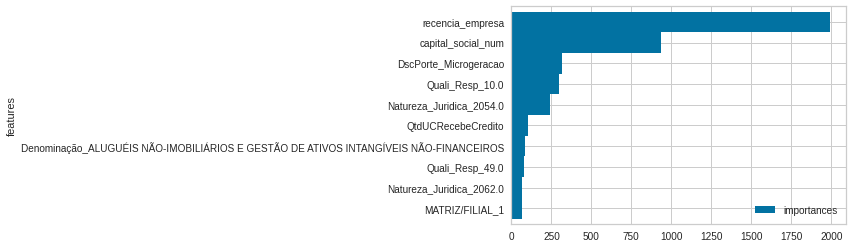

In [ ]:
#feature_importances_df
%matplotlib inline
feature_importances_df.head(10).sort_values(by='importances', ascending=True).set_index('features').plot(kind='barh', width=1.0)

#### 5 - Clusterização -

##### Recência Empresa - Contínua
##### Capital Social - Contínua
##### Qualificação Responsável - Categórica 
##### Natureza Jurídica - Categórica 
##### CNAE Principal - Categórica 

##### 5.1 - Variáveis Contínuas (Recência Empresa e Capital Social)

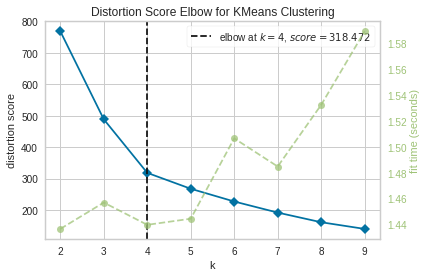

,cluster_fv,Recencia_media,recencia_minima,recencia_maxima,frequencia,Potencia_instalada_media
3,3,10831.3794,8342,14117,1568,33.2401
2,2,2306.1304,236,4075,2835,26.2595
1,1,17456.4892,14146,21999,774,42.1835
0,0,5848.1380,4082,8330,3479,27.2258


In [ ]:
## Recência Empresa

abt_recencia =(
    df_CNPJ_simples_abt
    .groupby('CNPJ')
    .agg(
        media_recencia=('recencia_empresa', 'mean'),
         recencia_minima=('recencia_empresa', 'min'),
         recencia_maxima=('recencia_empresa', 'max'),
         total_instalacoes=('CodEmpreendimento','count'),
         potencia_media=('MdaPotenciaInstaladaKW', 'mean'))
      .reset_index()
      )

abt_recencia['rank_recencia'] = abt_recencia['media_recencia'].rank(pct=True)
abt_recencia['rank_potencia'] = abt_recencia['potencia_media'].rank(pct=True)

kmeans = KMeans(n_clusters=4, random_state=15)
kmeans.fit(abt_recencia.set_index('CNPJ'))
abt_recencia['cluster_fv'] = kmeans.labels_
    
model = KMeans(random_state=15)
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(abt_recencia.filter(["rank_recencia","rank_potencia"]));
visualizer.show();


resultado_analise =(
    abt_recencia
    .groupby('cluster_fv')
    .agg(Recencia_media=('media_recencia', 'mean'),
         recencia_minima=('recencia_minima', 'min'),
         recencia_maxima=('recencia_maxima', 'max'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()

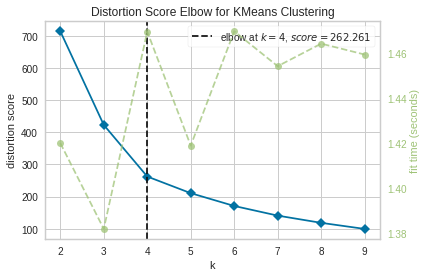

,cluster_fv,capital_media,capital_minima,capital_maxima,frequencia,Potencia_instalada_media
3,3,3023217539.6645,2044888470.7500,7342885463.5700,118,43.5705
2,2,18761020998.7637,12552162483.7500,30951382773.0000,35,464.2926
1,1,57347887873.9150,55000000000.0000,58130517165.2200,4,49.1350
0,0,2151748.1272,0.0000,1400000000.0000,8499,28.6098


In [ ]:
## Capital Social

abt_capital =(
    df_CNPJ_simples_abt
    .groupby('CNPJ')
    .agg(
        media_capital=('capital_social_num', 'mean'),
         capital_minima=('capital_social_num', 'min'),
         capital_maxima=('capital_social_num', 'max'),
         total_instalacoes=('CodEmpreendimento','count'),
         potencia_media=('MdaPotenciaInstaladaKW', 'mean'))
      .reset_index()
      )

abt_capital['rank_capital'] = abt_capital['media_capital'].rank(pct=True)
abt_capital['rank_potencia'] = abt_capital['potencia_media'].rank(pct=True)

kmeans = KMeans(n_clusters=4, random_state=15)
kmeans.fit(abt_capital.set_index('CNPJ'))
abt_capital['cluster_fv'] = kmeans.labels_
    
model = KMeans(random_state=15)
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(abt_capital.filter(["rank_capital","rank_potencia"]));
visualizer.show();


resultado_analise =(
    abt_capital
    .groupby('cluster_fv')
    .agg(capital_media=('media_capital', 'mean'),
         capital_minima=('capital_minima', 'min'),
         capital_maxima=('capital_maxima', 'max'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()

##### 5.2 Clusterização - Rank

In [ ]:
## Criar função paraclusterização
def clusterizacao_rank(var_cadastral,numero):
    abt =(
    df_CNPJ_simples_abt
    .groupby(var_cadastral)
    .agg(total_instalacoes=('CodEmpreendimento','count'),
         total_potencia=('MdaPotenciaInstaladaKW', 'sum'),
         total_potencia_media=('MdaPotenciaInstaladaKW', 'mean'))
    .reset_index()
    )
    abt['rank_pct_intalacoes'] = abt['total_instalacoes'].rank(pct=True)
    abt['rank_pct_potencia'] = abt['total_potencia'].rank(pct=True)

    kmeans = KMeans(n_clusters=numero, random_state=15)
    kmeans.fit(abt.set_index(var_cadastral))
    abt['cluster_fv'] = kmeans.labels_
    
    model = KMeans(random_state=15)
    visualizer = KElbowVisualizer(model, k=(2, 10))
    visualizer.fit(abt.filter(["rank_pct_intalacoes","rank_pct_potencia"]));
    visualizer.show();


    return abt

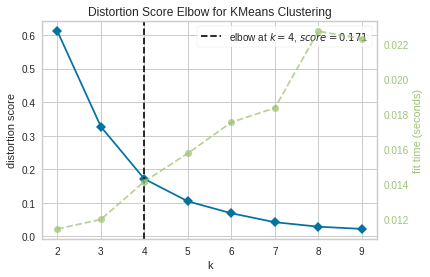

,cluster_fv,Potencia_instalada_total,frequencia,Potencia_instalada_media
3,3,96520.1300,2630,51.5801
2,2,108044.3200,3624,29.8136
1,1,54981.0900,2229,24.6663
0,0,3239.8400,173,19.1268


In [ ]:
## Clusterização por Natureza Jurídica (Quali_Resp)

abt_Quali_Resp = clusterizacao_rank('Quali_Resp',4)

resultado_analise =(
    abt_Quali_Resp
    .groupby('cluster_fv')
    .agg(Potencia_instalada_total=('total_potencia','sum'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('total_potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()

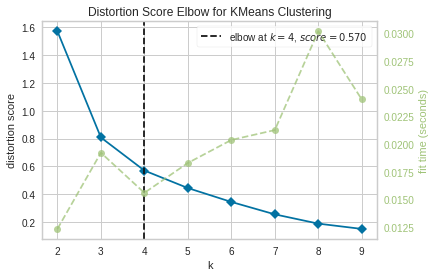

,cluster_fv,Potencia_instalada_total,frequencia,Potencia_instalada_media
3,3,71403.2600,2106,105.4073
2,2,54981.0900,2229,24.6663
1,1,119782.4600,3746,31.9761
0,0,16618.5700,575,64.3342


In [ ]:
## Clusterização por Natureza Jurídica (Criação por RANK)

abt_rank = clusterizacao_rank('Natureza_Juridica',4)

resultado_analise =(
    abt_rank
    .groupby('cluster_fv')
    .agg(Potencia_instalada_total=('total_potencia','sum'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('total_potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()


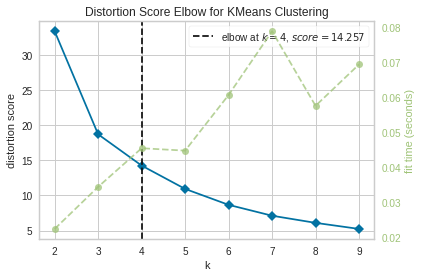

,cluster_fv,Potencia_instalada_total,frequencia,Potencia_instalada_media
3,3,14525.3500,277,52.4381
2,2,78969.0900,2733,59.0650
1,1,58373.2900,1587,140.8287
0,0,110917.6500,4059,31.6717


In [ ]:
## Clusterização por Natureza Jurídica (CNAE_PRINCIPAL2)

abt_CNAE_PRINCIPAL2 = clusterizacao_rank('CNAE_PRINCIPAL2',4)

resultado_analise =(
    abt_CNAE_PRINCIPAL2
    .groupby('cluster_fv')
    .agg(Potencia_instalada_total=('total_potencia','sum'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('total_potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()

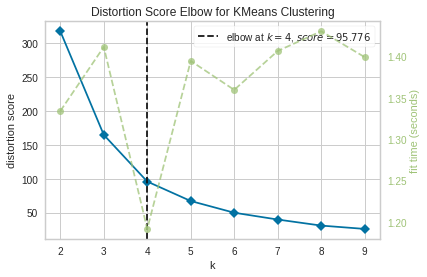

,cluster_fv,Potencia_instalada_total,frequencia,Potencia_instalada_media
3,3,13189.0400,22,737.5847
2,2,104649.1600,5769,19.1542
1,1,12689.2000,11,1678.3444
0,0,132257.9800,2854,61.2086


In [ ]:
## Clusterização por por recencia empresa)

abt_recencia = clusterizacao_rank('recencia_empresa',4)

resultado_analise =(
    abt_recencia
    .groupby('cluster_fv')
    .agg(Potencia_instalada_total=('total_potencia','sum'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('total_potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()

In [ ]:
abt_recencia.query('cluster_fv==0')

,recencia_empresa,total_instalacoes,total_potencia,total_potencia_media,rank_pct_intalacoes,rank_pct_potencia,cluster_fv
4,308,4,128.7600,32.1900,0.9450,0.9359,0
8,351,2,83.2000,41.6000,0.7301,0.8610,0
9,370,2,80.0000,40.0000,0.7301,0.8528,0
14,390,1,75.0000,75.0000,0.3059,0.8173,0
51,539,1,75.0000,75.0000,0.3059,0.8173,0
...,...,...,...,...,...,...,...
5042,20531,1,70.0000,70.0000,0.3059,0.7700,0
5043,20532,2,111.0000,55.5000,0.7301,0.9165,0
5046,20550,2,95.0000,47.5000,0.7301,0.8907,0
5048,20692,2,80.0000,40.0000,0.7301,0.8528,0


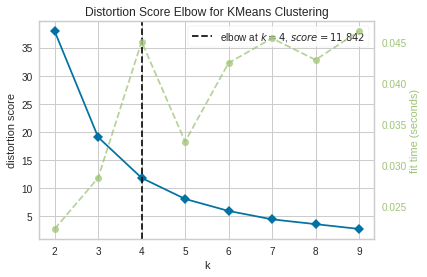

,cluster_fv,Potencia_instalada_total,frequencia,Potencia_instalada_media
3,3,17938.4800,444,40.4020
2,2,58805.1300,2088,111.3958
1,1,92828.1100,3559,26.0826
0,0,93213.6600,2565,51.3966


In [ ]:
## Clusterização por Natureza Jurídica (Capital social)

abt_capital_social = clusterizacao_rank('capital_social_num',4)

resultado_analise =(
    abt_capital_social
    .groupby('cluster_fv')
    .agg(Potencia_instalada_total=('total_potencia','sum'),
         frequencia=('total_instalacoes', 'sum'),
         Potencia_instalada_media =('total_potencia_media','mean'))
    .reset_index()
    .sort_values('cluster_fv', ascending=False))

resultado_analise.head()